# Evaluate spell checkers

This notebook presents an evaluation of some existing spell checkers on the collected evaluation SpellGram dataset. First, I'll introduce the metrics and spell checkers; then, we'll evaluate them.

## Metrics for evaluation

Let's introduce some steps of spell checking process:

1. Decide if a word is misspelled or not
2. If we get positive answer from the step 1, one needs to correct that misspelled word to make it correctly spelled

Figure below shows the schematic process of automatic spelling correction. **We'll be evaluating the final corrected result rather than detection and then correction separately**. (image source: [Survey of Automatic Spelling Correction](https://www.mdpi.com/2079-9292/9/10/1670))
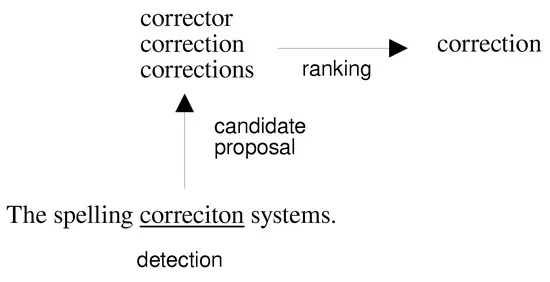

The evaluation metrics can be classified as follows:

1. Classification metrics of misspelled word correction: either 1 if corrected accurately or 0 otherwise
- **Accuracy** (Percentage of words that are corrected accurately)
- **Precision** (how many of the words flagged as incorrect were incorrect)
- **Recall** (how many of the actual misspelled words were correctly flagged)
- **F1-Score** (harmonic mean of precision and recall)

Advantage: easy and widely-used.

Disadvantage: only the best candidate from the suggestion list is considered.

2. Sequence-to-sequence evaluation metrics
- **bilingual-evaluation-understudy (BLEU)** (adapted from machine translation)
- **Word Error Rate (WER)** (widely used in Automatic Speech Recognition)

Advantage: easy and quick to implement.

Disadvantage: BLEU can't be calculated on a sentence level, only on a corpus level.

3. Information retrieval
- **Mean reciprocal rank**
- **Mean average precision**

Advantage: automatic spelling correction is similar to information retrieval so we can consider n best candidates.

Disadvantage: the candidate list must be large enough to contain the correct answer.

Sources:
1. [Survey of Automatic Spelling Correction](https://www.mdpi.com/2079-9292/9/10/1670)
2. [Foundations of NLP Explained — Bleu Score and WER Metrics](https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b)
3. [spell-checkers-comparison](https://github.com/diffitask/spell-checkers-comparison/blob/main/spell-checkers-comparison.ipynb)


----------------
In our evaluation, we'll use classification metrics to measure the percentage of corrected misspellings because we have quite simple misspellings that occur just once within one word.

**We'll calculate Accuracy/Precision/Recall/F1-Score** for each sentence (only considering the misspelled words) and then average them for all evaluation dataset.

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from typing import List, Tuple

In [3]:
def compute_metrics(source_sentences: List[str],
                    target_sentences: List[str],
                    corrected_sentences: List[str]) -> Tuple[float, float, float, float]:
    """
    Compute evaluation metrics given source, target and corrected sentences
    """

    assert len(source_sentences) == len(target_sentences) == len(corrected_sentences), "Needed to be of the same length!"

    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for source_sentence, target_sentence, corrected_sentence in zip(source_sentences, target_sentences, corrected_sentences):
        source_words = source_sentence.split()
        target_words = target_sentence.split()
        corrected_words = corrected_sentence.split()

        # If sentences have different lengths, you can truncate/pad for alignment
        max_len = max(len(source_words), len(target_words), len(corrected_words))
        source_words.extend([''] * (max_len - len(source_words)))
        target_words.extend([''] * (max_len - len(target_words)))
        corrected_words.extend([''] * (max_len - len(corrected_words)))

        y_true = []
        y_pred = []

        # Only evaluate for misspelled words
        for s_word, t_word, c_word in zip(source_words, target_words, corrected_words):
            if s_word != t_word:  # Word was misspelled in source
                y_true.append(1)  # "1" means the word needed correction
                if c_word == t_word:  # Corrected correctly
                    y_pred.append(1)  # "1" means it was corrected correctly
                else:
                    y_pred.append(0)  # Incorrect correction or not corrected at all

        # If there are misspelled words in the sentence, calculate the metrics
        if len(y_true) > 0:
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)

            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
        else:
            # If no misspelled words in this sentence, ignore or append zeros
            accuracies.append(1.0)  # 100% accuracy for sentences without misspelled words
            precisions.append(1.0)
            recalls.append(1.0)
            f1_scores.append(1.0)

    # Calculate average metrics across all sentences
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_precision = sum(precisions) / len(precisions)
    avg_recall = sum(recalls) / len(recalls)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    return avg_accuracy, avg_precision, avg_recall, avg_f1

## Existing approach. Pre-trained models and rule-based methods

Approach I chose for evaluation:

1. [spelling-correction-english-base](https://huggingface.co/oliverguhr/spelling-correction-english-base): Bart-based spell checker which was finetuned for the spelling correction task.
2. [Autocorrect](https://github.com/filyp/autocorrect): Spelling corrector in python based on rule-based methods.
3. [spellCheck](https://github.com/R1j1t/contextualSpellCheck): non-word error (NWE) correction using pretrained BERT model without finetuning.
4. [t5-base-spellchecker](https://huggingface.co/Bhuvana/t5-base-spellchecker): T5 Base-based (most probably) finetuned Spellchecker.

I chose this combination because I wanted to test both rule-based methods and pretrained language model-based methods. My guess is that the latter will handle spelling correction better because such models can catch semantics/syntax long dependencies when dealing with sentences.

-----------

Other spell checkers worth mentioning which we won't be evaluating here (for different reasons, including that some of them work on a word level or their main mechanism is similar to the ones I've already chosen):

- [Spell checker using T5 base transformer](Bhuvana/t5-base-spellchecker): A simple spell checker based on T5-Base transformer model.
- [TextBlob](https://textblob.readthedocs.io/en/dev/): is a Python library for processing textual data, spell correction is among other features. Based on the same method as Autocorrect.
- [Pyspellchecker](https://pypi.org/project/pyspellchecker/): simple spell checker based on a Levenshtein Distance algorithm to find permutations within an edit distance of 2 from the original word. Works on a word level.

Others:
- [Grammarly](https://www.grammarly.com/)
- [Ginger](https://www.gingersoftware.com/spellcheck)

and many more...it would take too much space to describe them all + their underlying mechanism repeat each other.


## Evaluate

Let's load our evaluation dataset and shuffle it (but keep the source-target connections)

In [4]:
import pandas as pd

eval_dataset = pd.read_csv("/content/SpellGram_dataset_2k.csv")
eval_dataset.head()

,Unnamed: 0,source,target
0,0,rate the silent upeaker four out oe 6,rate the silent speaker four out of 6
1,1,please find me tqe gork tqe bfrning sorld,please find me the work the burning world
2,2,three friendl afe relaxing uround the tsble,three friends are relaxing around the table
3,3,what dm they want,what do they want
4,4,man in tan aat working with stones,man in tan hat working with stones


In [5]:
eval_dataset = eval_dataset.sample(frac=1)
eval_texts = eval_dataset['source'].to_list()
target_texts = eval_dataset['target'].to_list()

### 1. Finetuned Bart transformer model

In [6]:
from transformers import pipeline
import torch
import string
from tqdm import tqdm

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
fix_spelling = pipeline("text2text-generation",
                        model="oliverguhr/spelling-correction-english-base",
                        device=device)

In [9]:
bart_predictions = []

for text in tqdm(eval_texts):
    prediction = fix_spelling(text,max_length=2048)[0]['generated_text']
    clean_prediction = prediction.translate(str.maketrans('', '', string.punctuation))
    bart_predictions.append(clean_prediction.lower())

100%|██████████| 2000/2000 [04:57<00:00,  6.72it/s]


Calculate metrics for Bart predictions

In [10]:
avg_accuracy, avg_precision, avg_recall, avg_f1 = compute_metrics(eval_texts,
                                                                  target_texts,
                                                                  bart_predictions)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")

Average Accuracy: 0.7670
Average Precision: 0.8770
Average Recall: 0.7670
Average F1 Score: 0.8039


### 2. Autocorrect

In [ ]:
!pip install autocorrect

In [12]:
from autocorrect import Speller

In [13]:
spell = Speller()

In [14]:
autocorrect_predictions = []

for text in tqdm(eval_texts):
    prediction = spell(text)
    autocorrect_predictions.append(prediction)

100%|██████████| 2000/2000 [02:00<00:00, 16.56it/s]


In [15]:
avg_accuracy, avg_precision, avg_recall, avg_f1 = compute_metrics(eval_texts,
                                                                  target_texts,
                                                                  autocorrect_predictions)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")

Average Accuracy: 0.5233
Average Precision: 0.7140
Average Recall: 0.5233
Average F1 Score: 0.5817


### 3. spellCheck

In [ ]:
!pip install contextualSpellCheck

In [ ]:
import contextualSpellCheck
import spacy

In [ ]:
nlp = spacy.load("en_core_web_sm")
contextualSpellCheck.add_to_pipe(nlp)

In [ ]:
spellcheck_predictions = []

for text in tqdm(eval_texts):
    doc = nlp(text)
    spellcheck_predictions.append(doc._.outcome_spellCheck.lower())

100%|██████████| 2000/2000 [28:02<00:00,  1.19it/s]


In [ ]:
avg_accuracy, avg_precision, avg_recall, avg_f1 = compute_metrics(eval_texts,
                                                                  target_texts,
                                                                  spellcheck_predictions)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")

Average Accuracy: 0.3429
Average Precision: 0.5165
Average Recall: 0.3429
Average F1 Score: 0.3916


### 4. T5 Base Spellchecker

In [ ]:
! pip install accelerate

In [29]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
tokenizer = AutoTokenizer.from_pretrained("Bhuvana/t5-base-spellchecker")
model = AutoModelForSeq2SeqLM.from_pretrained("Bhuvana/t5-base-spellchecker", device_map=device)

In [37]:
def correct(inputs: str) -> str:
    """
    Predict correctly spelled sentence using pretrained T5 base model
    """

    input_ids = tokenizer.encode(inputs,return_tensors='pt').to(device)
    sample_output = model.generate(
        input_ids,
        do_sample=True,
        max_length=5000,
        top_p=0.99,
        num_return_sequences=1
    )
    res = tokenizer.decode(sample_output[0], skip_special_tokens=True)
    return res

In [45]:
t5base_predictions = []

for text in tqdm(eval_texts):
    t5base_predictions.append(correct(text))

100%|██████████| 2000/2000 [08:56<00:00,  3.73it/s]


In [46]:
avg_accuracy, avg_precision, avg_recall, avg_f1 = compute_metrics(eval_texts,
                                                                  target_texts,
                                                                  t5base_predictions)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")

Average Accuracy: 0.3823
Average Precision: 0.4985
Average Recall: 0.3823
Average F1 Score: 0.4179


## Summary

### **General observations**

In the table below you can see evaluation results of all 4 approach I used on the evaluation dataset.
- As expected, pretrained language model (Bart-based) handled the task most accurately among others, however, another language model (T5-based) showed quite low metrics. The potential reason for that is that while T5 model can be powerful for complex tasks such as machine translation, it could struggle with small-scale corrections (like spelling errors) on a token level.

- Moreover, I got surprisingly low results on Bert-based approach (spellCheck) which might be explained by the fact that the base Bert model wasn't finetuned for the spelling correction task (unlike the Bart-based one).

- Autocorrect got the second place among other approach which is not that bad considering that it's an algorithm-based approach.

| Approach | Accuracy | Precision | Recall | F1-Score |
|----------|----------|----------|----------|----------|
|   **Bart-based model** |   **0.767**  |   **0.877**  | **0.767**  | **0.804** |
|   Autocorrect  |   0.523  |   0.714  | 0.523  | 0.582 |
|   T5-based model  |   0.382  |   0.499  | 0.382  | 0.418  |
|   spellCheck |   0.343  |   0.517  | 0.343  | 0.392  |



### **Strengths and weaknesses**

### 1. Rule-based approach
Let's see Autocorrect's mistakes made in spelling correction

In [17]:
for s_sent, t_sent, p_sent in zip(eval_texts[:10], target_texts[:10], autocorrect_predictions[:10]):
  for s_word, t_word, p_word in zip(s_sent.split(), t_sent.split(), p_sent.split()):
          if s_word != t_word and p_word != t_word:
            print(t_sent)
            print("source word:", s_word)
            print("target word:", t_word)
            print("predicted word:", p_word)
            print('-'*10)

nor did he consider his decision a particularly courageous one
source word: she
target word: he
predicted word: she
----------
the hail pattered on the burnt brown grass
source word: patteled
target word: pattered
predicted word: battled
----------
the hail pattered on the burnt brown grass
source word: grajj
target word: grass
predicted word: gray
----------
your rusty bicycle chain could use some lube
source word: rusth
target word: rusty
predicted word: rush
----------
two further instances of this name in celtic sources may also be included jes
source word: ir
target word: in
predicted word: ir
----------
the constant changes of sultans that followed led to great disorder in the provinces
source word: yn
target word: in
predicted word: yn
----------
the impact of a drought on a society
source word: n
target word: on
predicted word: n
----------
she will recover from this shock
source word: fom
target word: from
predicted word: fom
----------
that all sounds a bit of a kerfuffle
sou

Pros:

- Fast, takes up little memory resources

Cons:

- Misses semantics/syntax
- Might have problems with catching real word errors (misspelled string is a valid word in the language)
- Might struggle with names/cities/etc.
- Might not handle more complex misspellings, it stuggles even with several misspellings within one sentence

### 2. Language model-based approach

Let's explore Bart-based model's mistakes in spelling correction (I don't take Bert-based and T5-based models because they showed worse results).

In [18]:
for s_sent, t_sent, p_sent in zip(eval_texts[:10], target_texts[:10], bart_predictions[:10]):
  for s_word, t_word, p_word in zip(s_sent.split(), t_sent.split(), p_sent.split()):
          if s_word != t_word and p_word != t_word:
            print(t_sent)
            print("source word:", s_word)
            print("target word:", t_word)
            print("predicted word:", p_word)
            print('-'*10)

nor did he consider his decision a particularly courageous one
source word: she
target word: he
predicted word: she
----------
the hail pattered on the burnt brown grass
source word: patteled
target word: pattered
predicted word: patteled
----------
the hail pattered on the burnt brown grass
source word: grajj
target word: grass
predicted word: graj
----------
your rusty bicycle chain could use some lube
source word: rusth
target word: rusty
predicted word: rust
----------
that all sounds a bit of a kerfuffle
source word: rhar
target word: that
predicted word: rhar
----------
that all sounds a bit of a kerfuffle
source word: acc
target word: all
predicted word: acc
----------
richards died of a heart attack soon after his arrival
source word: heat
target word: heart
predicted word: heat
----------


Pros:
- Many incorrectly made corrections are semantically and syntactically appropriate. Moreover, a misspelled word might be ambiguous even for the human to correct (for example, one might correct *fetsts* to *tests* in *they conduct annual technical fests which are attended by students from around the nation*). So, we might say that there mistakes can occur due to the samples ambiguity but not the model itself
- High accuracy

Cons:
- More heavy in terms of memory and speed of processing
- Needed to be finetuned
- Ranking of candidates should be considered since there can be several potentially good solutions

### Conclusion

Overall, I see large language models approach as a favorable one for the spelling correction task because they are more robust, able to handle more complex misspellings without losing contextual meaning.

For the future research I would search for more data especially for more complex cases (for example, ones of dyslexic adult people or typos made in haste), and also with several misspellings within one word. I believe that the quality of the training dataset will play one the most crucial roles in this task. Then, by carefully finetuning a large Language model one can get a nice spell checker.

It's important to consider other evaluation metrics to evaluate not only the first and most plausible candidate for the correction but *n* most suitable ones. One can also explore the words which were not supposed to be changed but they were changed by a model.

Moreover, one can add syntactic corrections and better writing practices suggestions.